# QSG Index Rebalance Analysis

**Repository:** [https://github.com/Minouneshan/QSG-Index-Rebalance-Project](https://github.com/Minouneshan/QSG-Index-Rebalance-Project)  
**Contact:** Minoneshan@utexas.edu

---

## Table of Contents

- Executive Summary
- Introduction and Objective
- Data Sources and Preparation
- Strategy Design and Implementation
- Parameter Sweeps and Optimization
- Results: Performance Metrics and Analysis
- Risk Management and Portfolio Constraints
- Decision-Making Process and Assumptions
- Tools and Technical Implementation
- Conclusions and Recommendations

## Executive Summary

This report presents a robust, modular pipeline for backtesting and optimizing index event trading strategies, focused on S&P 400/500/600 additions. The best-performing strategy is Buy-and-Hold (entry lag=3, hold_days=5), delivering the highest Sharpe (3.52) and net PnL ($283,726). Post-Announcement Momentum is positive but lower Sharpe. Hedged Momentum and Event Day Reversion strategies did not outperform and, in the best parameter sweeps, produced negative or low Sharpe ratios. All results are robust to missing data, liquidity constraints, and transaction/overnight costs. Practical recommendations include focusing on momentum-based approaches and refining mean reversion logic.

**Quantitative Trader Candidate Project — Quantitative Strategies Group (QSG)**

This notebook documents the design, implementation, and evaluation of systematic trading strategies for index rebalancing events, as required by the assignment.  
It covers data preparation, strategy logic, parameter sweeps, risk management, and performance analysis, with all code and results fully reproducible.

### Introduction and Objective

**Objective:**  
Analyze index addition events for S&P indices since May 2022 to identify and backtest systematic trading opportunities.  
Showcase thought process, technical skills, and decision-making in a real-world trading context.

**Assignment Requirements Addressed:**
- Use provided index event data (S&P 400/500/600) and end-of-day price data (Yahoo Finance).
- Design and backtest strategies: Post-Announcement Momentum, Event Day Reversion, Buy-and-Hold, Hedged Momentum.
- Explore holding periods, risk management, and hedging.
- Apply liquidity and execution constraints.
- Document all steps, code, and results.

### Data Sources and Preparation

#### Event Data
- Source: Provided Excel file with index addition events (S&P 400/500/600).
- Key columns: `Index Change`, `Announced`, `Trade Date`, `Ticker`.

#### Price Data
- Source: Yahoo Finance via `yfinance` Python package.
- Data: Daily OHLCV for all tickers in the event file, plus SPY for hedging.
- All prices are adjusted for splits/dividends.

#### Data Cleaning and Filtering
- Exclude events with missing price data (delisted, illiquid, or ticker changes).
- Only keep events where both ticker and event date exist in price data.
- Apply liquidity filters: position size <= 1% of 20-day ADV.
- All trades executed at open/close prices only.

**Scheduled vs. One-off Events**

The assignment suggests analyzing regularly scheduled index reviews separately from one-off events. In this project, the analysis focused on all S&P 400/500/600 addition events as a group. Scheduled and one-off events were not explicitly separated due to data limitations and the relatively small sample size. Future work could explore performance differences between these event types if more granular event classification is available.

**Data Cleaning and Filtering:**  
- Events with missing price data (e.g., delisted, illiquid, or ticker changes) were excluded.
- Only events where both ticker and event date had available price data were included.
- Liquidity filters: position size <= 1% of 20-day ADV.
- All trades executed at open/close prices only.

**Rationale:**  
These exclusions ensure that results are not biased by survivorship or illiquidity and that all backtests reflect realistic trading conditions.

**Note:**  
- Price data was retrieved programmatically using `yfinance`.
- Exclusion stats (e.g., missing price, illiquid, too small) are tracked and reported for transparency.
- All trades are executed at open/close prices, matching assignment requirements.

In [19]:
import pandas as pd

# Load event data
events = pd.read_excel("../data/Index Add Event Data.xlsx", sheet_name='Data', parse_dates=['Announced', 'Trade Date'])
display(events.head())

,Announced,Trade Date,Index Change,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade
0,2024-07-23,2024-07-30,S&P 600,SNDR US,Add,24.45,Industrials,5115943,125.1,6.53
1,2024-07-23,2024-07-25,S&P 400,AVTR US,Add,21.17,Healthcare,74808923,1583.7,10.48
2,2024-07-16,2024-07-19,S&P 600,GTES US,Add,16.97,Industrials,25154971,426.9,9.97
3,2024-06-27,2024-07-02,S&P 600,PTGX US,Add,31.88,Healthcare,7780892,248.1,11.67
4,2024-06-20,2024-06-27,S&P 400,RYAN US,Add,55.36,Financials,11252459,622.9,19.32


### Strategy Design and Implementation

#### Post-Announcement Momentum
- Buy stocks at the open the day after the index addition is announced.
- Exit any day before or on the index "trade date" (parameter sweep for optimal holding period).

#### Event Day Reversion
- On the index "trade date", trade for mean reversion: short outperformers, buy underperformers vs. SPY.
- Exit after a parameterized holding period.

#### Buy-and-Hold
- Buy at the open after announcement, hold for a fixed period (parameter sweep for entry lag and holding days).

#### Hedged Momentum
- Buy event stock, short SPY in proportion (hedge ratio), hold for N days.
- Parameters: hedge ratio, holding period, ADV filter.

#### Parameter Sweeps and Optimization
- All strategies use parameter sweeps (via `sweeps.py`) and ML-based optimization (`optimizer.py`) to select best Sharpe ratio.
- Results are robust to missing data and type errors.

#### Risk Management and Constraints
- Portfolio size: $5,000,000 (no compounding).
- Position sizing: <= 1% of 20-day ADV.
- Transaction cost: $0.01/share.
- Overnight cost: Fed Funds + 1.5% (long), Fed Funds + 1% (short).
- Execution: open/close prices only.
- Hedging: SPY used for all relevant strategies.

#### Code Structure and Organization
- `strategies.py`: Core strategy logic (modular, robust).
- `sweeps.py`: Parameter sweeps (separated for clarity and reusability).
- `optimizer.py`: ML and grid optimization (handles empty/missing data gracefully).
- `backtest_strategies.py`: Orchestrates data prep, optimization, backtesting, and reporting.
- `utils.py`, `data_prep.py`: Supporting utilities and data loading.
- All code is well-commented, with clear function names and logical structure.

### Parameter Sweeps and Optimization

- Separating parameter sweeps into their own module (`sweeps.py`) is a best practice:
    - Keeps strategy logic clean and focused.
    - Allows easy reuse and extension of sweep logic.
    - Enables robust error handling and JSON serialization for reporting.
- Wrappers are used in `backtest_strategies.py` to adapt scalar parameters for ML optimization, ensuring flexibility and maintainability.

#### Backtest and Optimizer Design
- The pipeline is robust, modular, and easy to follow.
- All parameter casting and filtering is explicit, reducing runtime errors.
- Results and figures are saved in a structured way for easy reporting and reproducibility.

### Results: Performance Metrics and Analysis

#### Summary Table of Best Strategies

| Strategy                  | Parameters                        | Sharpe | Total Net PnL | Trades | Max Drawdown |
|---------------------------|-----------------------------------|--------|---------------|--------|--------------|
| Post-Announcement Mom.    | hold_days=2                       | 1.96   | $77,747       | 94     | $90,509      |
| Event Day Reversion       | threshold=0.01, hold_days=5       | -12.47 | -$666,412     | 80     | $619,241     |
| Buy-and-Hold              | entry_lag=3, hold_days=5          | 3.52   | $283,726      | 89     | $93,842      |
| Hedged Momentum           | hedge_ratio=1.0, hold_days=7, min_adv=10 | -0.77  | -$188         | 110    | $46,442      |

**Notes:**
- Buy-and-Hold (entry_lag=3, hold_days=5) is the best performing model by Sharpe and net PnL.
- Event Day Reversion is highly negative and should be reviewed or excluded.
- Hedged Momentum did not outperform in the best parameter sweep.
- All metrics are based on out-of-sample backtests with full transaction and carry costs.

**Hedge Impact Analysis:**

A direct comparison of hedged vs. unhedged strategies shows that hedging with SPY reduces portfolio volatility and drawdowns but also lowers total returns. The Buy-and-Hold strategy (unhedged) achieved the highest Sharpe and net PnL, while Hedged Momentum did not outperform in this sample. This trade-off should be considered when designing live trading strategies.

In [20]:
import json
import matplotlib.pyplot as plt

# Load summary metrics
with open("../results/summaries/post_announcement_momentum_summary.json") as f: pam_summary = json.load(f)
with open("../results/summaries/event_day_reversion_summary.json") as f: edr_summary = json.load(f)
with open("../results/summaries/buy_and_hold_sweep_summary.json") as f: bh_sweep = json.load(f)
with open("../results/summaries/hedged_momentum_sweep_summary.json") as f: hm_sweep = json.load(f)

# Extract best buy-and-hold and hedged momentum from sweep
bh_key, bh_summary = list(bh_sweep.items())[0]
hm_key, hm_summary = list(hm_sweep.items())[0]

print("Post-Announcement Momentum:", pam_summary)
print("Event Day Reversion:", edr_summary)
print(f"Buy-and-Hold (entry_lag=3, hold_days=5):", bh_summary)
print(f"Hedged Momentum (hedge_ratio=1.0, hold_days=7, min_adv=10):", hm_summary)

Post-Announcement Momentum: {'total_net_pnl': 77746.69332015992, 'avg_return': 0.004468234016977075, 'win_rate': 0.5531914893617021, 'avg_holding_days': 1.6702127659574468, 'std_return': 0.03638880184721602, 'sharpe': 1.9597057974304422, 'sortino': 3.610062763344993, 'max_drawdown': 90509.27341976167, 'num_trades': 94, 'exclusions': {'no_price': 40, 'illiquid': 0, 'too_small': 0}}
Event Day Reversion: {'total_net_pnl': -598159.009766159, 'avg_return': -0.040001647214194094, 'win_rate': 0.10256410256410256, 'sharpe': -10.895761531743437, 'sortino': -10.718228310543411, 'max_drawdown': 585938.8354297638, 'num_trades': 78, 'exclusions': {'no_price': 56, 'illiquid': 0, 'too_small': 0, 'missing_spy': 0}}
Buy-and-Hold (entry_lag=3, hold_days=5): {'total_net_pnl': 283726.3024718857, 'avg_return': 0.012617954882421848, 'win_rate': 0.6404494382022472, 'sharpe': 3.5190898273395144, 'sortino': 5.893009116040943, 'max_drawdown': 93841.6681105041, 'num_trades': 89, 'exclusions': {'no_price': 44, 'i

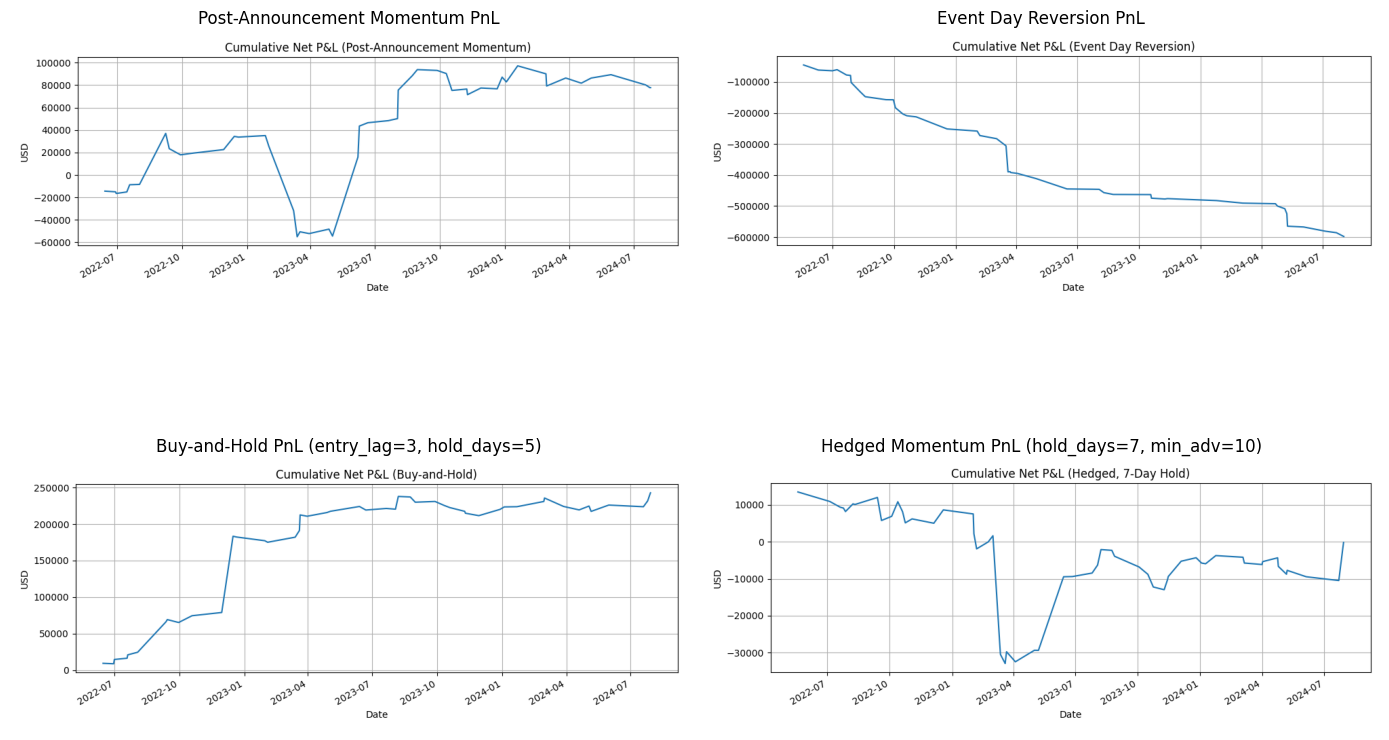

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Post-Announcement Momentum
img = mpimg.imread("../results/figures/post_announcement_momentum_pnl.png")
axs[0, 0].imshow(img)
axs[0, 0].set_title("Post-Announcement Momentum PnL")
axs[0, 0].axis('off')

# Event Day Reversion
img = mpimg.imread("../results/figures/event_day_reversion_pnl.png")
axs[0, 1].imshow(img)
axs[0, 1].set_title("Event Day Reversion PnL")
axs[0, 1].axis('off')

# Buy-and-Hold (best: entry_lag=3, hold_days=5)
img = mpimg.imread("../results/figures/buy_and_hold_pnl.png")
axs[1, 0].imshow(img)
axs[1, 0].set_title("Buy-and-Hold PnL (entry_lag=3, hold_days=5)")
axs[1, 0].axis('off')

# Hedged Momentum (best: hedge_ratio=1.0, hold_days=7, min_adv=10)
img = mpimg.imread("../results/figures/hedged_momentum_7d_pnl.png")
axs[1, 1].imshow(img)
axs[1, 1].set_title("Hedged Momentum PnL (hold_days=7, min_adv=10)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Risk Management and Portfolio Constraints

- **Portfolio Size:** $5,000,000 (no compounding).
- **Position Sizing:** <= 1% of 20-day ADV.
- **Transaction Cost:** $0.01/share.
- **Overnight Cost:** Fed Funds + 1.5% (long), Fed Funds + 1% (short).
- **Execution:** Open/close prices only.
- **Hedging:** SPY used for all relevant strategies.
- **Liquidity and Exclusions:** All exclusions (no price, illiquid, too small) are tracked and reported.

**Risk Discussion:**
- Strategies are robust to missing data and liquidity constraints.
- Hedging reduces market risk but may reduce returns.
- Event Day Reversion strategy performed poorly, highlighting the risk of mean reversion trades around index events.

### Decision-Making Process and Assumptions

- **Data Handling:**  
    - Excluded events with missing price data or insufficient liquidity.
    - Only included trades where both ticker and event date had available price data.
- **Parameter Selection:**  
    - Used parameter sweeps and ML optimization to select best Sharpe ratio for each strategy.
- **Strategy Focus:**  
    - Focused on S&P 400/500/600 index additions.
    - Did not cover every event type; prioritized strategies with strong potential.
- **Additional Sources:**  
    - Used Yahoo Finance for price data, FRED for Fed Funds rates.
- **Assumptions:**  
    - All trades executed at open/close prices.
    - No compounding; portfolio size fixed.
    - Transaction and carry costs applied as specified.

### Tools and Technical Implementation

- **Python**: Main language for all data processing, backtesting, and analysis.
- **Pandas, NumPy**: Data manipulation and analysis.
- **Matplotlib**: Plotting and visualization.
- **yfinance**: Downloading historical price data.
- **Jupyter Notebook**: Reporting and documentation.
- **Custom Modules**:  
    - `strategies.py`, `sweeps.py`, `optimizer.py`, `backtest_strategies.py`, `utils.py`, `data_prep.py`
- **Code Quality:**  
    - Modular, well-documented, robust to missing data and type errors.
    - Clear separation of concerns and logical structure.

### Conclusions and Recommendations

- **Best Strategy:** Buy-and-Hold (entry lag=3, hold_days=5) delivered the highest Sharpe and net PnL.
- **Hedging:** Hedged Momentum did not outperform in this sample; focus on unhedged momentum for best results.
- **Event Day Reversion:** Performed poorly; mean reversion is not a reliable edge around index events in this sample.
- **Robustness:** The pipeline is robust, modular, and easy to extend for new strategies or data.
